In [92]:
import scanpy as sc
import anndata as ad
import pandas as pd
import gzip
import matplotlib.pyplot as plt
import seaborn as sns

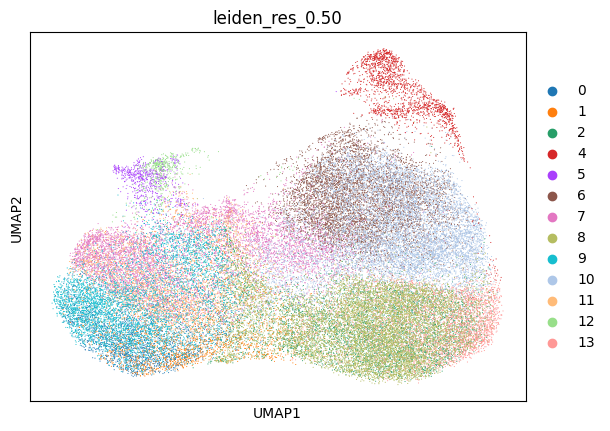

In [26]:
adata = sc.read_h5ad("integrated_data.h5ad")

clustering = "leiden_res_0.35"

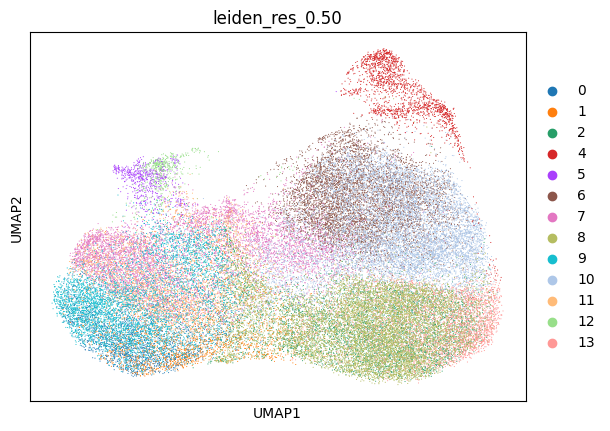

AnnData object with n_obs × n_vars = 51421 × 19307
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'mito_percentage', 'n_genes', 'doublet_score', 'predicted_doublet', 'leiden', 'source', 'leiden_res_0.02', 'leiden_res_0.35', 'leiden_res_0.50', 'leiden_res_2.00', 'cell_type_lvl1', 'umap_density_source'
    uns: 'dendrogram_leiden_res_0.50', 'leiden_res_0.02', 'leiden_res_0.02_colors', 'leiden_res_0.35', 'leiden_res_0.50', 'leiden_res_0.50_colors', 'leiden_res_2.00', 'leiden_res_2.00_colors', 'neighbors', 'pca', 'rank_genes_groups', 'source_colors', 'umap', 'umap_density_source_params', 'log1p', 't-test'
    obsm: 'X_pca', 'X_umap'
   

In [34]:
sc.pl.umap(adata, color=clustering)
adata

In [29]:
dc_cluster_genes = sc.get.rank_genes_groups_df(adata, group="7").head(5)["names"]
sc.pl.umap(
    adata,
    color=[*dc_cluster_genes, clustering],
    legend_loc="on data",
    frameon=False,
    ncols=3,
)

KeyError: 'names'

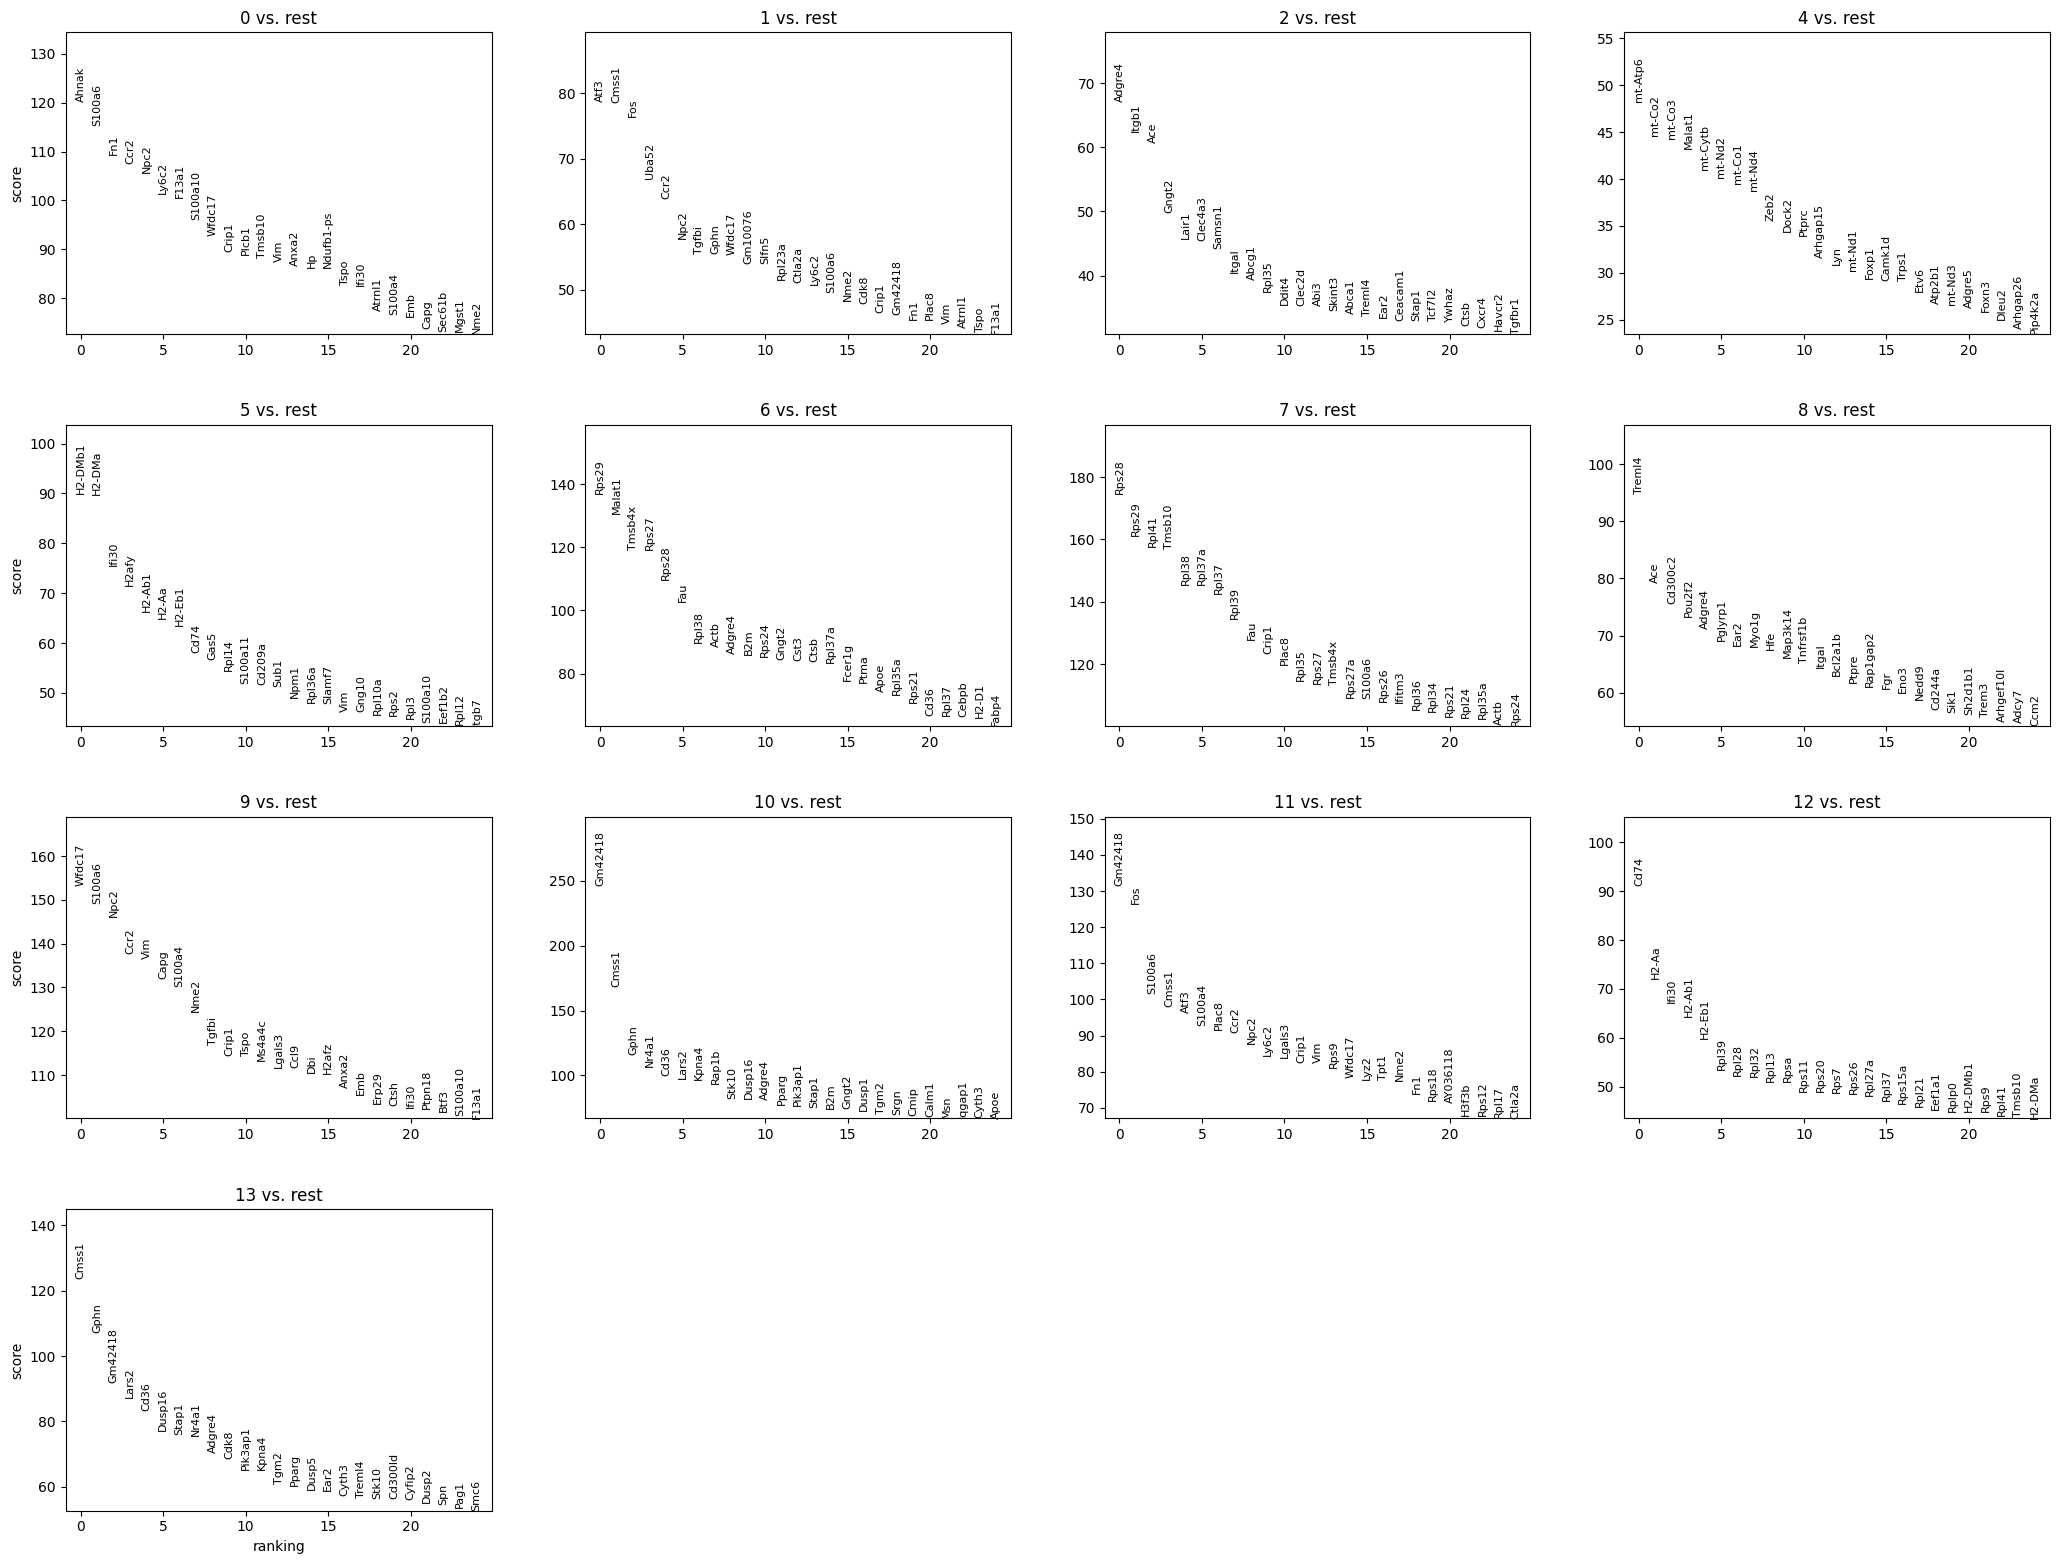

AnnData object with n_obs × n_vars = 51421 × 19307
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'mito_percentage', 'n_genes', 'doublet_score', 'predicted_doublet', 'leiden', 'source', 'leiden_res_0.02', 'leiden_res_0.35', 'leiden_res_0.50', 'leiden_res_2.00', 'cell_type_lvl1', 'umap_density_source'
    uns: 'dendrogram_leiden_res_0.50', 'leiden_res_0.02', 'leiden_res_0.02_colors', 'leiden_res_0.35', 'leiden_res_0.50', 'leiden_res_0.50_colors', 'leiden_res_2.00', 'leiden_res_2.00_colors', 'neighbors', 'pca', 'rank_genes_groups', 'source_colors', 'umap', 'umap_density_source_params', 'log1p', 't-test'
    obsm: 'X_pca', 'X_umap'
   

In [31]:
adata.layers["counts"] = adata.X.copy() #copies raw count matrix into a new layer "counts", so raw data is preserved

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

#adata = adata.raw.to_adata()
#sc.pl.umap(adata, color='louvain_0.6')

sc.tl.rank_genes_groups(adata, clustering, method='t-test', key_added = "t-test", use_raw=False)
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "t-test", use_raw=False)

# results are stored in the adata.uns["t-test"] slot
adata

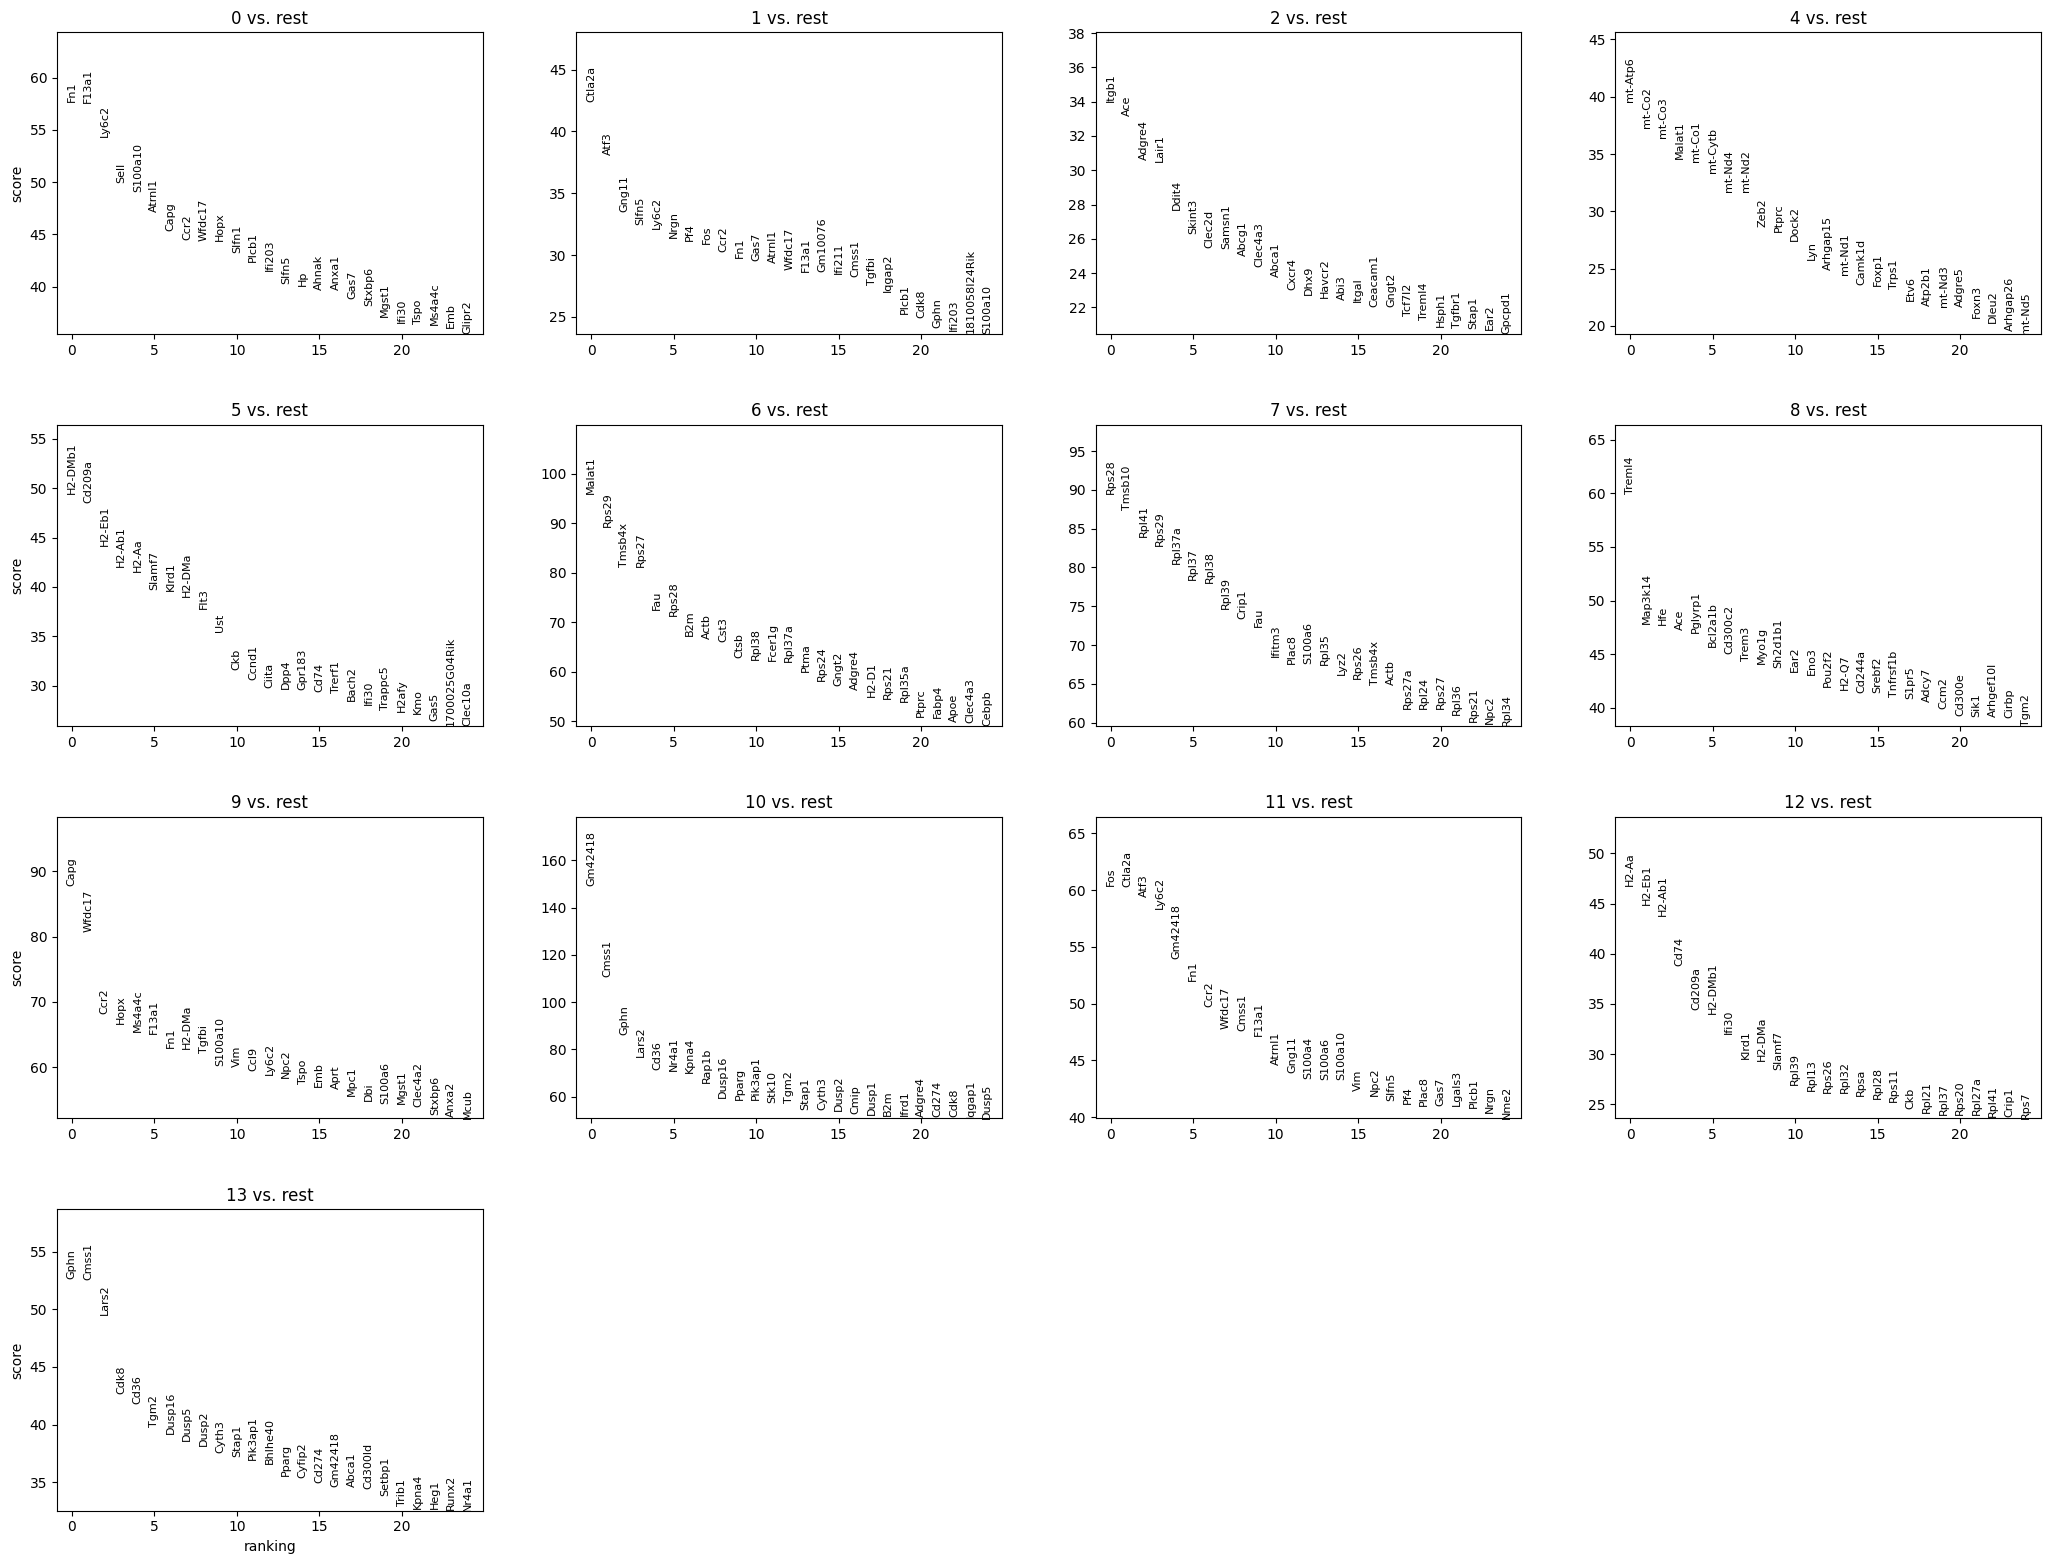

In [35]:
sc.tl.rank_genes_groups(adata, clustering, method='t-test_overestim_var', key_added = "t-test_ov")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "t-test_ov")

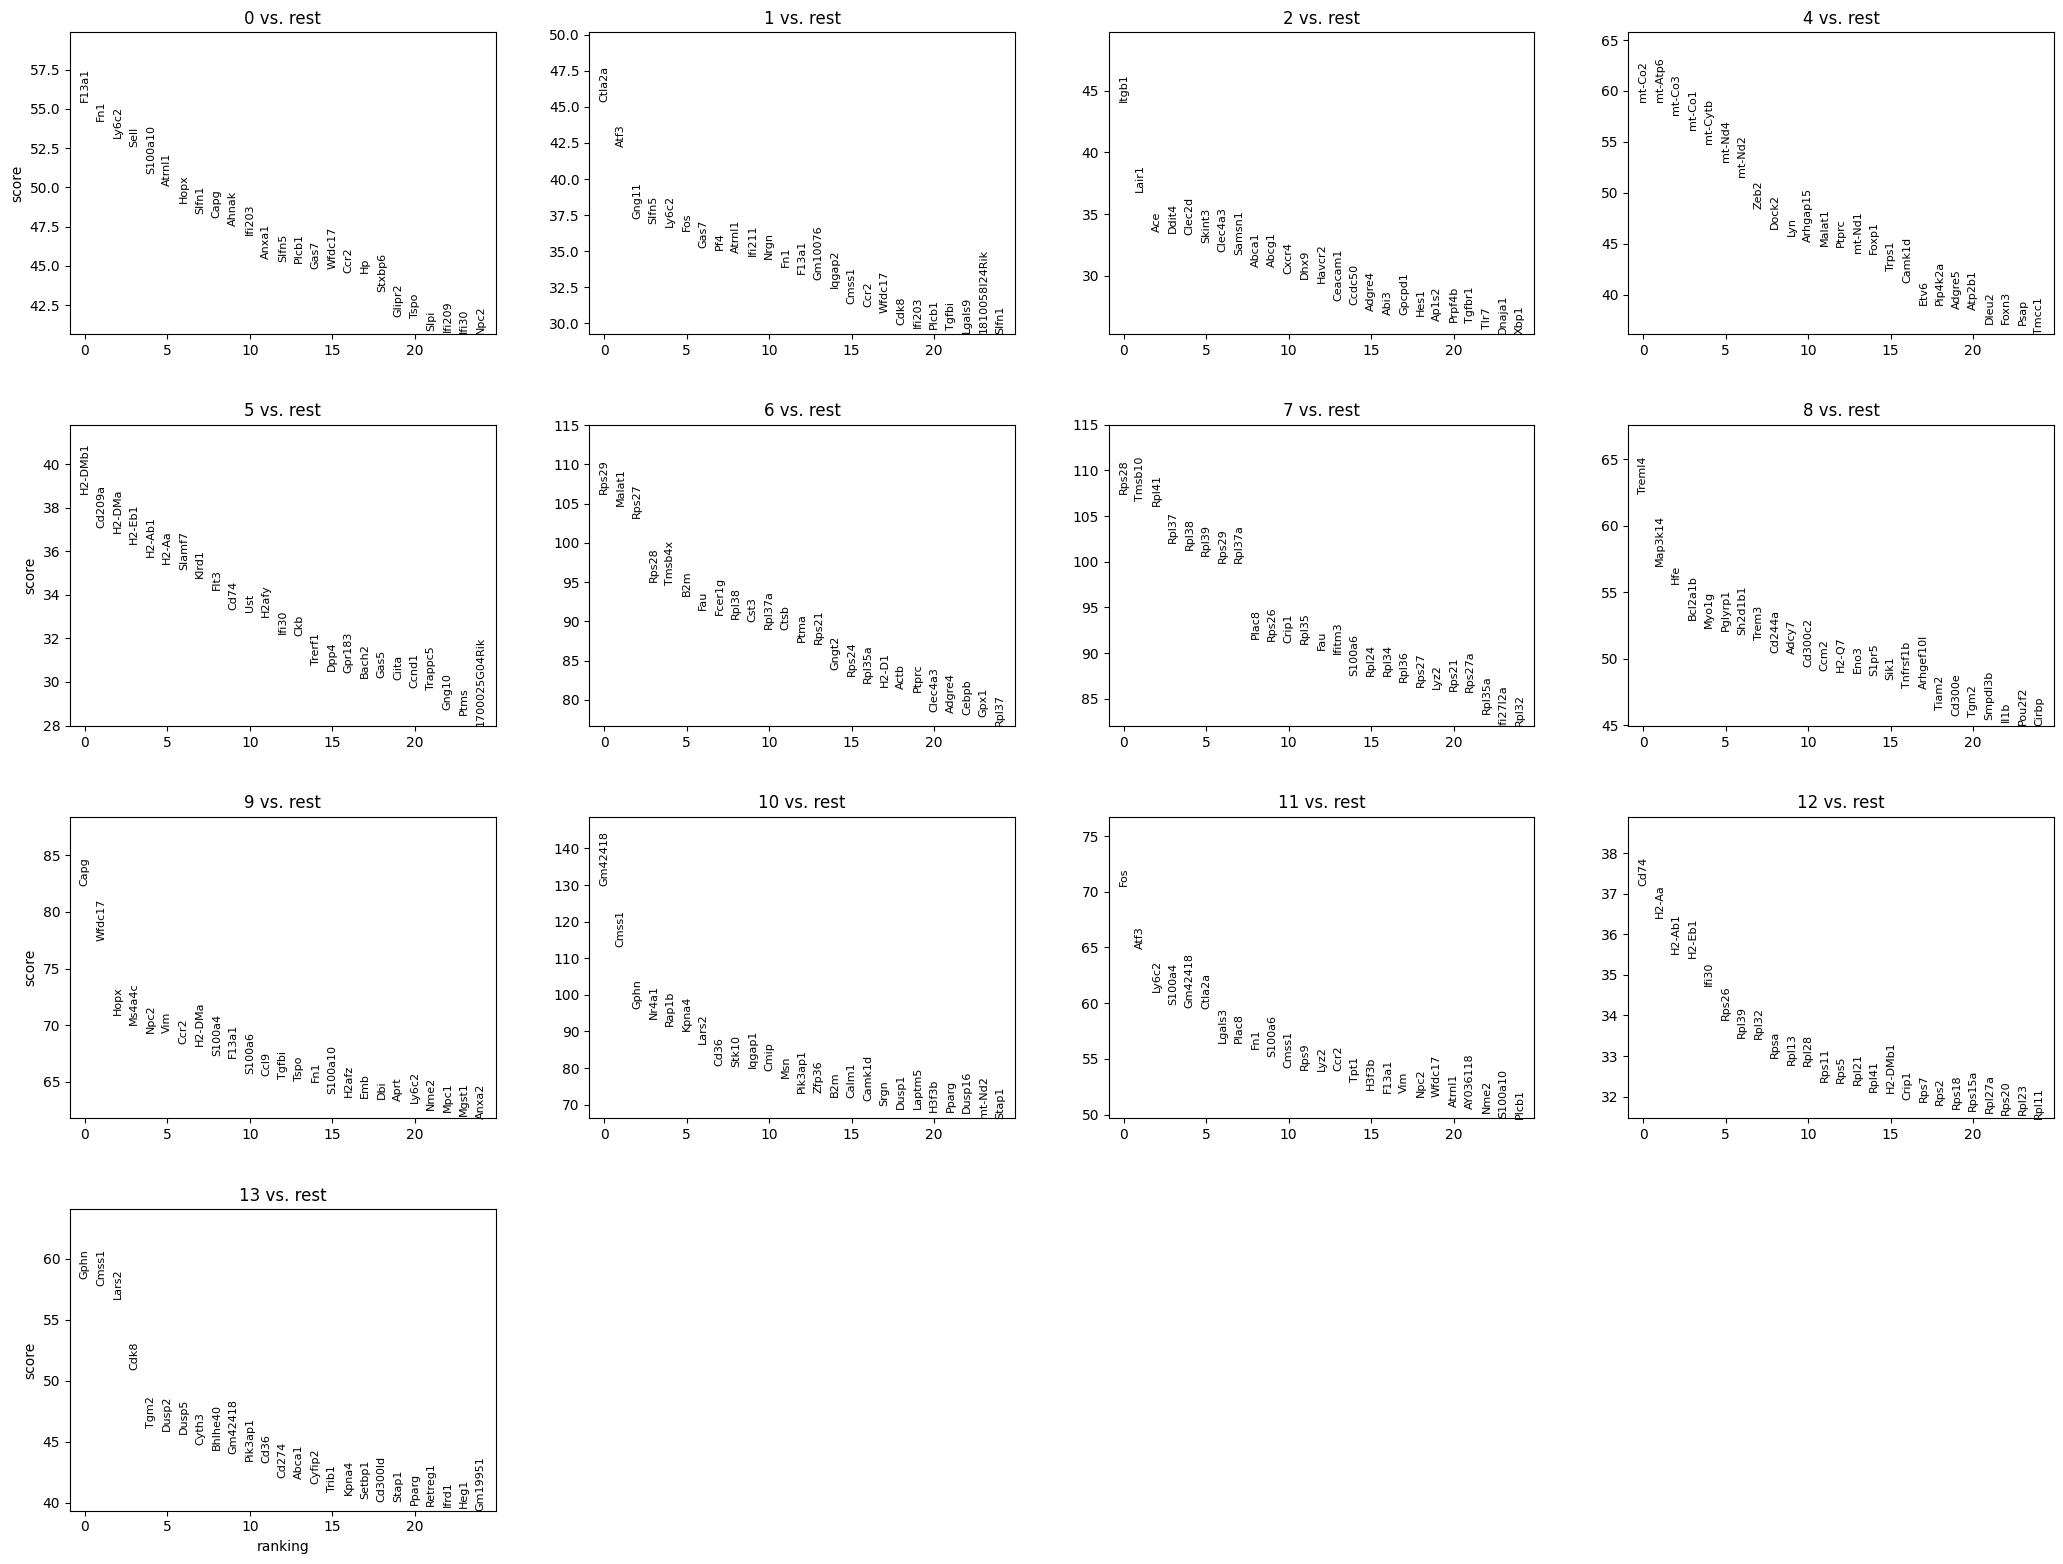

In [39]:
sc.tl.rank_genes_groups(adata, clustering, method='wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key="wilcoxon")

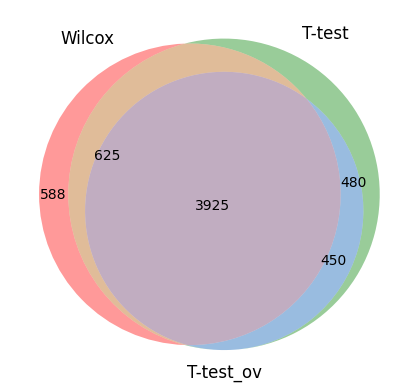

In [40]:
# WILCOX TEST
#compare cluster1 genes, only stores top 100 by default

wc = sc.get.rank_genes_groups_df(adata, group='0', key='wilcoxon', pval_cutoff=0.01, log2fc_min=0)['names']
tt = sc.get.rank_genes_groups_df(adata, group='0', key='t-test', pval_cutoff=0.01, log2fc_min=0)['names']
tt_ov = sc.get.rank_genes_groups_df(adata, group='0', key='t-test_ov', pval_cutoff=0.01, log2fc_min=0)['names']

from matplotlib_venn import venn3

venn3([set(wc),set(tt),set(tt_ov)], ('Wilcox','T-test','T-test_ov') )
plt.show()

monocytes: clusters [1, 2, 5, 7, 9, 11]
                 1   2   4   5   6   7   8   9   10  11  12  13
monocytes         2   1   0   0   0   1   0   2   0   3   0   0
T cells           0   0   0   0   0   0   0   0   0   0   0   0
NK cells          0   0   0   0   0   0   0   0   0   0   0   0
B cells           0   0   0   0   0   0   0   0   0   0   0   0
Neutrophils       0   0   0   0   0   0   0   0   0   0   0   0
dendritic cells   0   0   0   1   0   0   0   0   0   0   0   0


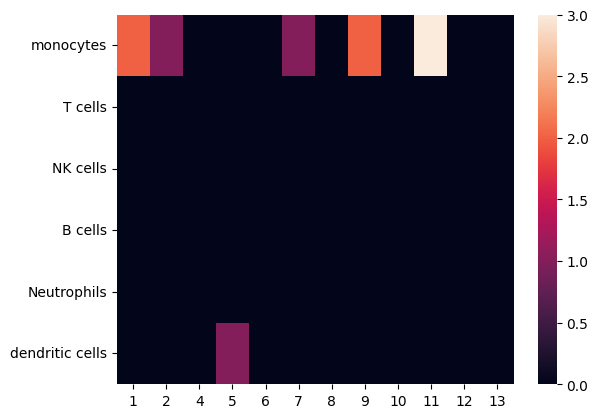

In [116]:
# Identifying clusters by cell type

cell_markers = {"monocytes": ["Itgam", "Plac8", #(should be high in all monocytes) 
    "Csf1r", "Ly6c2", "Cx3cr1", "Ace", "Spn", "Ccr2"], #(in biger subsets of monocytes)
    "T cells": ["Cd3e", "Cd3g", "Cd3e"], #(some can express Ly6c2)
    "NK cells": ["Nkg7", "Gzma"],
    "B cells": ["Cd79a", "Cd79b"],
    "Neutrophils": ["Ly6g", "Csf3r"], #(note: aslo express Itgam)
    "dendritic cells": ["Clec10a", "Clec9a", "Xcr1", "Flt3"], #(note: also express Itgam)
}
clusters = [1,2,4,5,6,7,8,9,10,11,12,13]

cluster_cell_types = {}
for cluster in clusters:
    marker_counts = {"monocytes": 0, "T cells": 0, "NK cells": 0, "B cells": 0, "Neutrophils": 0, "dendritic cells": 0}
    for cell in list(cell_markers.keys()):
        top_genes = list(sc.get.rank_genes_groups_df(adata, group=str(cluster), key='wilcoxon', pval_cutoff=0.01, log2fc_min=0)['names'][:25])
        for gene in top_genes:
            if gene in cell_markers[cell]:
                if cell == ""
                marker_counts[cell] += 1
    cluster_cell_types[cluster] = marker_counts

cct = pd.DataFrame(cluster_cell_types)
sns.heatmap(cct)

print(f"monocytes: clusters {list(cct.loc[:,cct.sum(axis=0) > 0].columns)}")

print(cct)

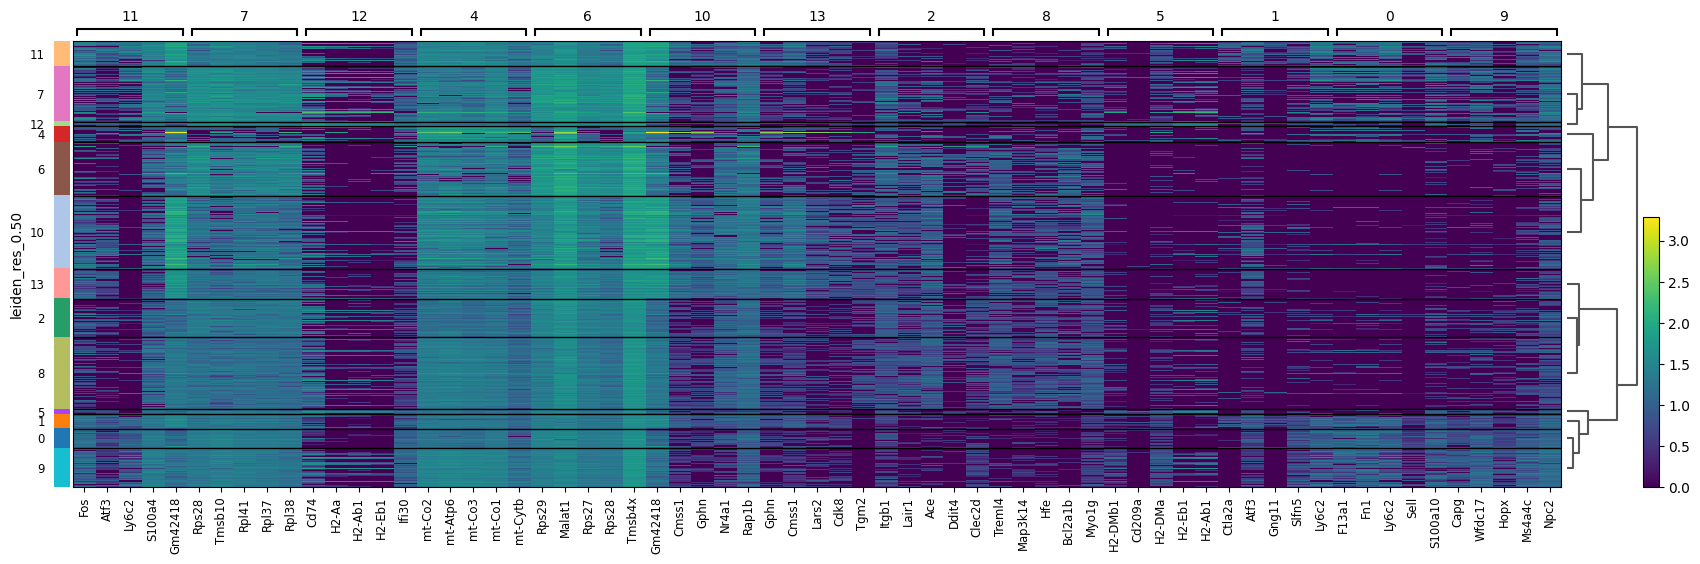

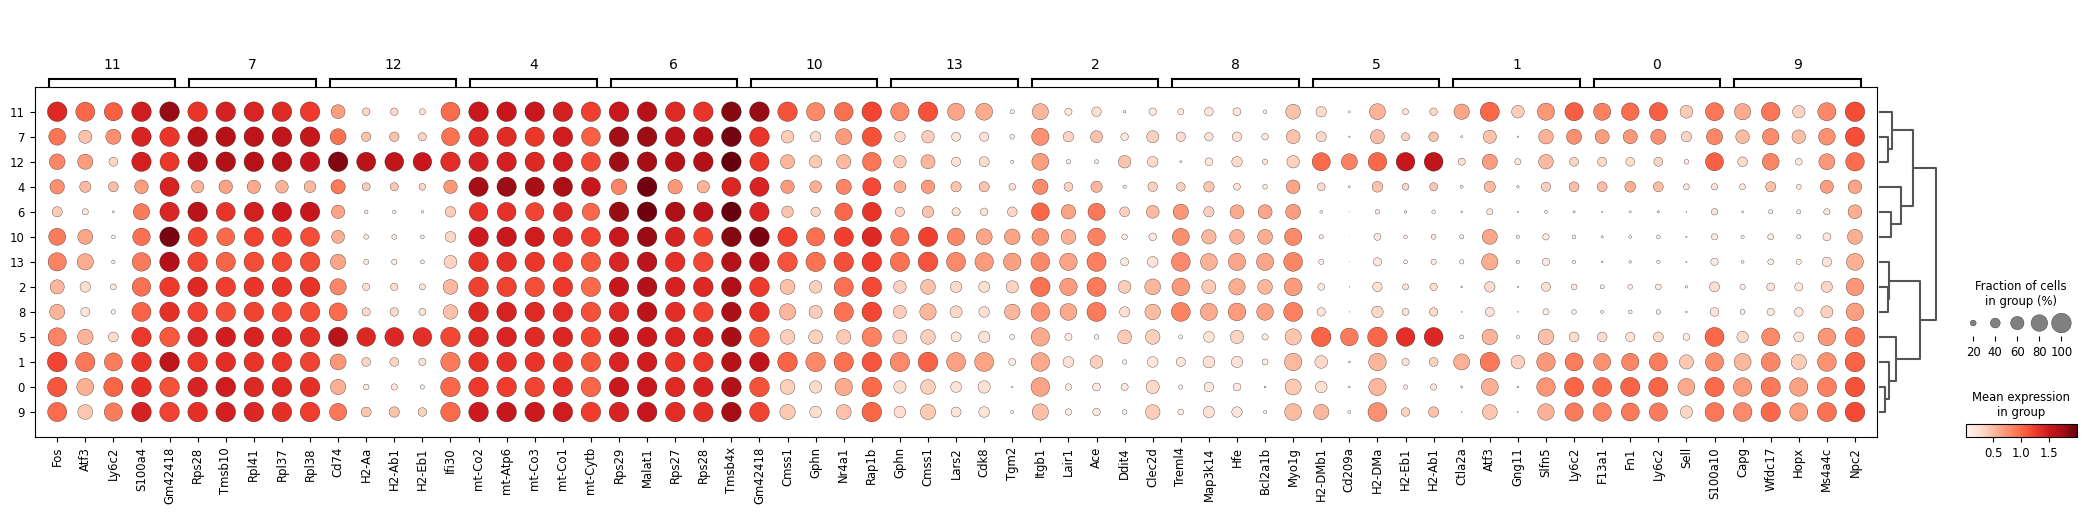

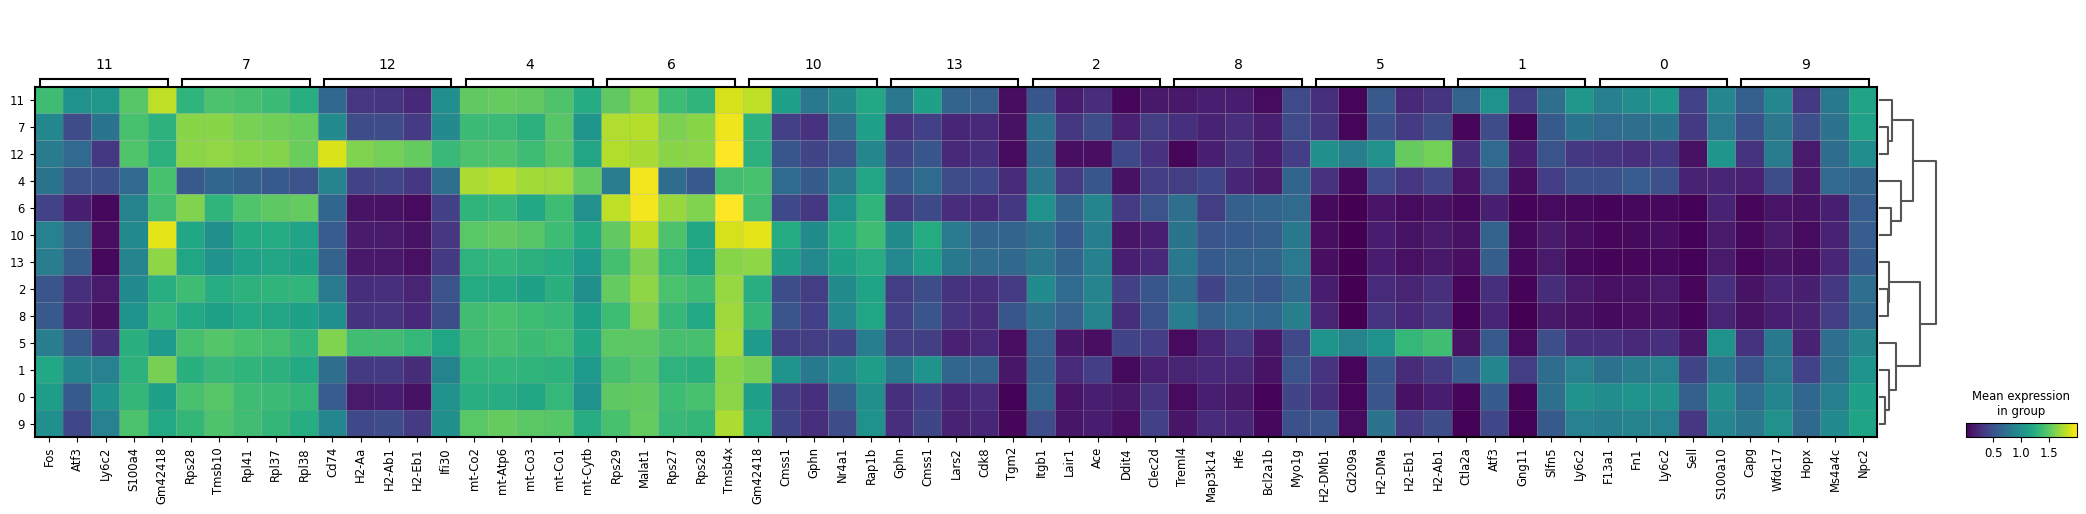

In [ ]:
sc.tl.dendrogram(adata, groupby=clustering)
sc.pl.rank_genes_groups_heatmap(adata, n_genes=5, key="wilcoxon", groupby=clustering, show_gene_labels=True)
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, key="wilcoxon", groupby=clustering)
#sc.pl.rank_genes_groups_stacked_violin(adata, n_genes=5, key="wilcoxon", groupby=clustering)
sc.pl.rank_genes_groups_matrixplot(adata, n_genes=5, key="wilcoxon", groupby=clustering)

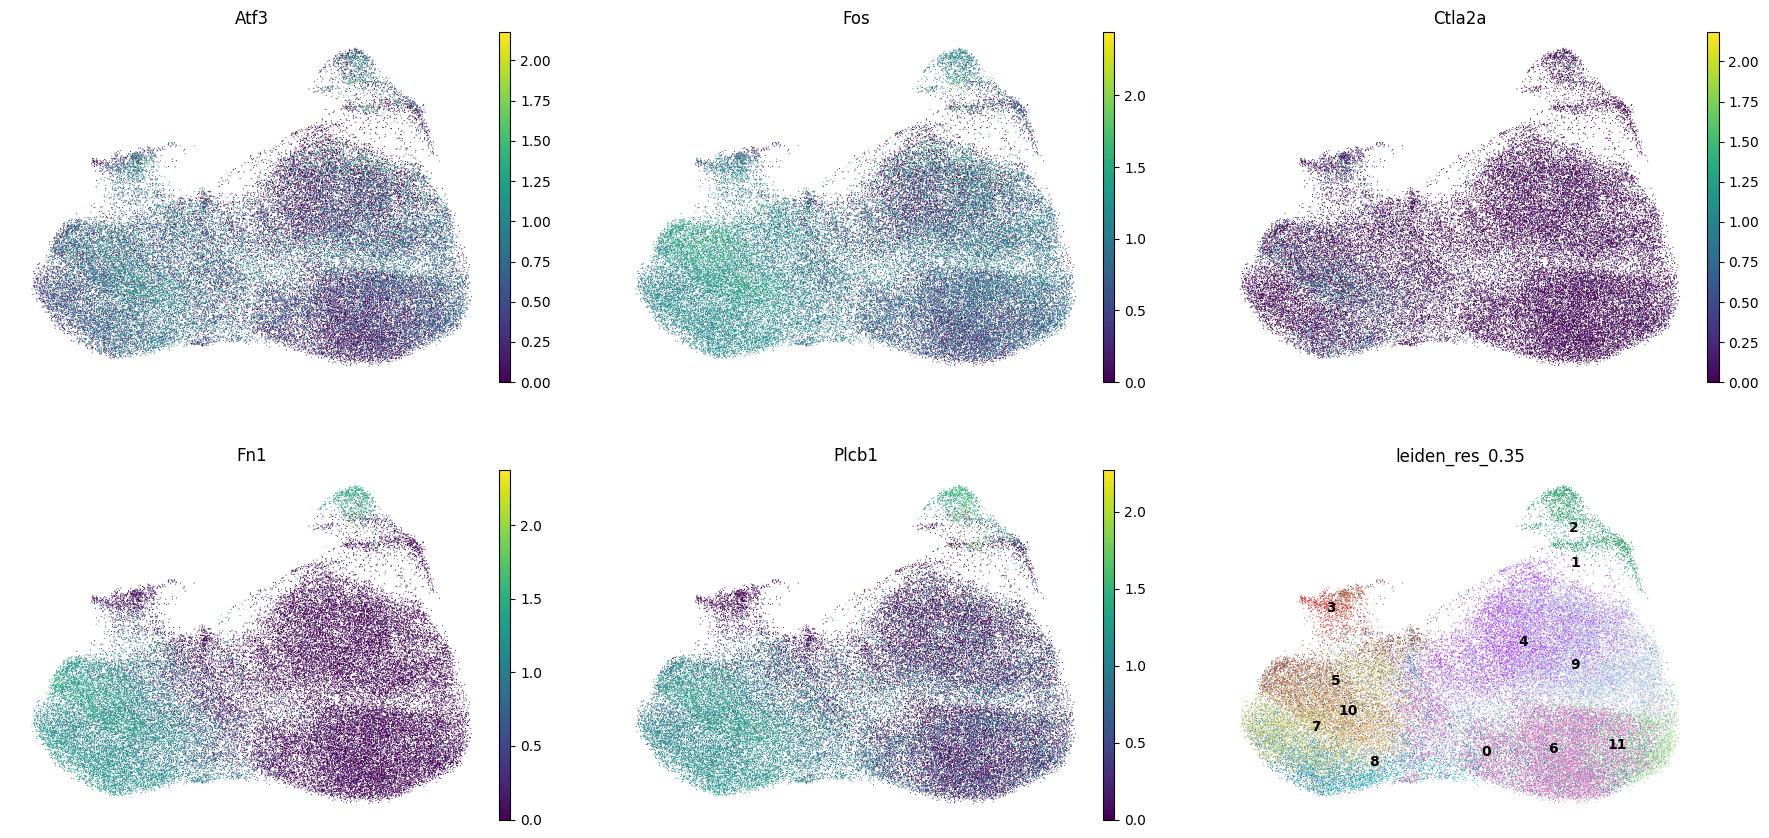

In [ ]:
sc.pl.umap(
    adata,
    color=[*dc_cluster_genes, clustering],
    legend_loc="on data",
    frameon=False,
    ncols=3,
)

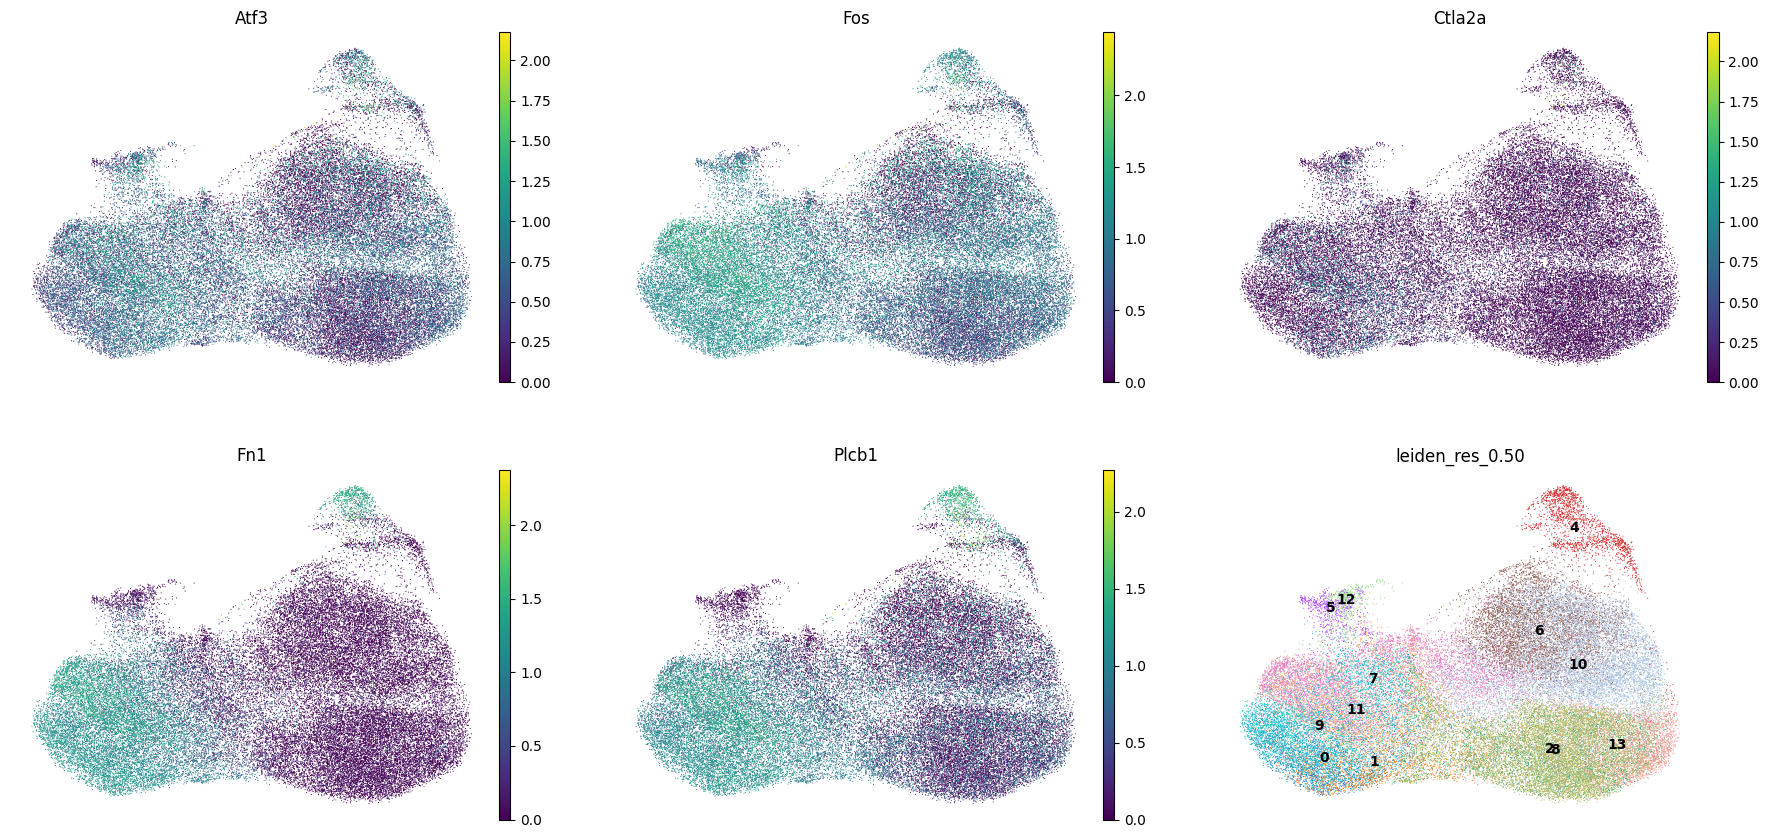

In [115]:
sc.pl.umap(
    adata,
    color=[*dc_cluster_genes, "leiden_res_0.50"],
    legend_loc="on data",
    frameon=False,
    ncols=3,
)

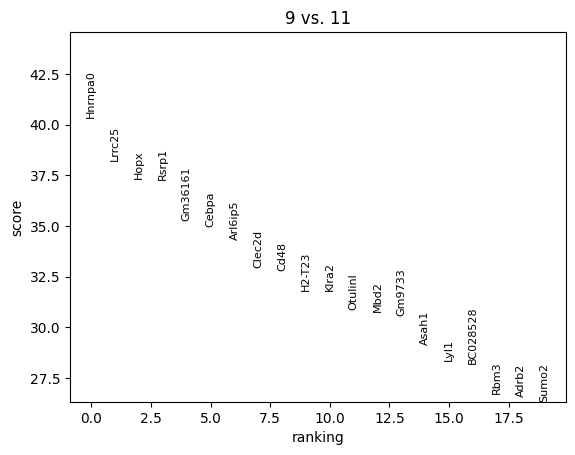

c:\Users\Hew\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\plotting\_tools\__init__.py:1314: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


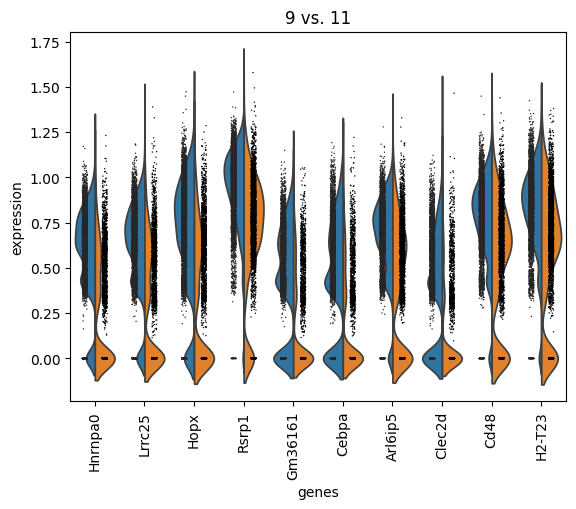

In [ ]:
# COMPARE CLUSTERS PAIRWISE

pair = ("9","11")

sc.tl.rank_genes_groups(adata, clustering, groups=[pair[0]], reference=pair[1], method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=[pair[0]], n_genes=20)

sc.pl.rank_genes_groups_violin(adata, groups=[pair[0]], n_genes=10)

# plot the same genes as violins across all the datasets.

# convert numpy.recarray to list
#mynames = [x[0] for x in adata.uns['rank_genes_groups']['names'][:10]]
#sc.pl.stacked_violin(adata, mynames, groupby = clustering)

# source = "12"

In [127]:
adata.obs

n_genes_by_counts  \
AAACCCACAAAGCTCT-1-12w_KO_01_processed.h5ad               3887   
AAACCCACATTCATCT-1-12w_KO_01_processed.h5ad               2897   
AAACCCAGTGATGTAA-1-12w_KO_01_processed.h5ad               3639   
AAACCCATCGAGTCTA-1-12w_KO_01_processed.h5ad               1923   
AAACCCATCGCAACAT-1-12w_KO_01_processed.h5ad               3757   
...                                                        ...   
TTTGTTGGTCTGATAC-1-ss_WT_processed.h5ad                   2899   
TTTGTTGTCGAGGCAA-1-ss_WT_processed.h5ad                   2653   
TTTGTTGTCTCCGAAA-1-ss_WT_processed.h5ad                   2574   
TTTGTTGTCTGGGCAC-1-ss_WT_processed.h5ad                   2932   
TTTGTTGTCTTTGCTA-1-ss_WT_processed.h5ad                   3656   

                                             log1p_n_genes_by_counts  \
AAACCCACAAAGCTCT-1-12w_KO_01_processed.h5ad                 8.265650   
AAACCCACATTCATCT-1-12w_KO_01_processed.h5ad                 7.971776   
AAACCCAGTGATGTAA-1-12w_KO_01_processed.h5ad                 8.199739   
AAACCCATCGAGTCTA-1-12w_KO_01_processed.h5ad                 7.562162   
AAACCCATCGCAACAT-1-12w_KO_01_processed.h5ad                 8.231642   
...                                                              ...   
TTTGTTGGTCTGATAC-1-ss_WT_processed.h5ad                     7.972466   
TTTGTTGTCGAGGCAA-1-ss_WT_processed.h5ad                     7.883823   
TTTGTTGTCTCCGAAA-1-ss_WT_processed.h5ad                     7.853605   
TTTGTTGTCTGGGCAC-1-ss_WT_processed.h5ad                     7.983781   
TTTGTTGTCTTTGCTA-1-ss_WT_processed.h5ad                     8.204398   

                                             total_counts  log1p_total_counts  \
AAACCCACAAAGCTCT-1-12w_KO_01_processed.h5ad       16861.0            9.732818   
AAACCCACATTCATCT-1-12w_KO_01_processed.h5ad        9618.0            9.171495   
AAACCCAGTGATGTAA-1-12w_KO_01_processed.h5ad       12097.0            9.400795   
AAACCCATCGAGTCTA-1-12w_KO_01_processed.h5ad        3832.0            8.251403   
AAACCCATCGCAACAT-1-12w_KO_01_processed.h5ad       15109.0            9.623112   
...                                                   ...                 ...   
TTTGTTGGTCTGATAC-1-ss_WT_processed.h5ad            7794.0            8.961238   
TTTGTTGTCGAGGCAA-1-ss_WT_processed.h5ad            6464.0            8.774158   
TTTGTTGTCTCCGAAA-1-ss_WT_processed.h5ad            6666.0            8.804925   
TTTGTTGTCTGGGCAC-1-ss_WT_processed.h5ad            7626.0            8.939450   
TTTGTTGTCTTTGCTA-1-ss_WT_processed.h5ad           12709.0            9.450145   

                                             pct_counts_in_top_50_genes  \
AAACCCACAAAGCTCT-1-12w_KO_01_processed.h5ad                   22.804104   
AAACCCACATTCATCT-1-12w_KO_01_processed.h5ad                   24.786858   
AAACCCAGTGATGTAA-1-12w_KO_01_processed.h5ad                   20.476151   
AAACCCATCGAGTCTA-1-12w_KO_01_processed.h5ad                   19.128392   
AAACCCATCGCAACAT-1-12w_KO_01_processed.h5ad                   26.209544   
...                                                                 ...   
TTTGTTGGTCTGATAC-1-ss_WT_processed.h5ad                       20.695407   
TTTGTTGTCGAGGCAA-1-ss_WT_processed.h5ad                       20.560025   
TTTGTTGTCTCCGAAA-1-ss_WT_processed.h5ad                       21.437144   
TTTGTTGTCTGGGCAC-1-ss_WT_processed.h5ad                       17.571466   
TTTGTTGTCTTTGCTA-1-ss_WT_processed.h5ad                       22.566685   

                                             pct_counts_in_top_100_genes  \
AAACCCACAAAGCTCT-1-12w_KO_01_processed.h5ad                    32.376490   
AAACCCACATTCATCT-1-12w_KO_01_processed.h5ad                    35.818257   
AAACCCAGTGATGTAA-1-12w_KO_01_processed.h5ad                    30.065305   
AAACCCATCGAGTCTA-1-12w_KO_01_processed.h5ad                    27.400835   
AAACCCATCGCAACAT-1-12w_KO_01_processed.h5ad                    37.275796   
...                                                      

In [156]:
adata.obs["genotype"] = ((adata.obs["source"] == "12w_KO_01_processed.h5ad") | (adata.obs["source"] == "12w_KO_02_processed.h5ad")).astype(int)
# source == 12k01 etc. = cluster 1, WT = cluster 2 -> genotype column instead of clustering variable
adata.obs


n_genes_by_counts  \
AAACCCACAAAGCTCT-1-12w_KO_01_processed.h5ad               3887   
AAACCCACATTCATCT-1-12w_KO_01_processed.h5ad               2897   
AAACCCAGTGATGTAA-1-12w_KO_01_processed.h5ad               3639   
AAACCCATCGAGTCTA-1-12w_KO_01_processed.h5ad               1923   
AAACCCATCGCAACAT-1-12w_KO_01_processed.h5ad               3757   
...                                                        ...   
TTTGTTGGTCTGATAC-1-ss_WT_processed.h5ad                   2899   
TTTGTTGTCGAGGCAA-1-ss_WT_processed.h5ad                   2653   
TTTGTTGTCTCCGAAA-1-ss_WT_processed.h5ad                   2574   
TTTGTTGTCTGGGCAC-1-ss_WT_processed.h5ad                   2932   
TTTGTTGTCTTTGCTA-1-ss_WT_processed.h5ad                   3656   

                                             log1p_n_genes_by_counts  \
AAACCCACAAAGCTCT-1-12w_KO_01_processed.h5ad                 8.265650   
AAACCCACATTCATCT-1-12w_KO_01_processed.h5ad                 7.971776   
AAACCCAGTGATGTAA-1-12w_KO_01_processed.h5ad                 8.199739   
AAACCCATCGAGTCTA-1-12w_KO_01_processed.h5ad                 7.562162   
AAACCCATCGCAACAT-1-12w_KO_01_processed.h5ad                 8.231642   
...                                                              ...   
TTTGTTGGTCTGATAC-1-ss_WT_processed.h5ad                     7.972466   
TTTGTTGTCGAGGCAA-1-ss_WT_processed.h5ad                     7.883823   
TTTGTTGTCTCCGAAA-1-ss_WT_processed.h5ad                     7.853605   
TTTGTTGTCTGGGCAC-1-ss_WT_processed.h5ad                     7.983781   
TTTGTTGTCTTTGCTA-1-ss_WT_processed.h5ad                     8.204398   

                                             total_counts  log1p_total_counts  \
AAACCCACAAAGCTCT-1-12w_KO_01_processed.h5ad       16861.0            9.732818   
AAACCCACATTCATCT-1-12w_KO_01_processed.h5ad        9618.0            9.171495   
AAACCCAGTGATGTAA-1-12w_KO_01_processed.h5ad       12097.0            9.400795   
AAACCCATCGAGTCTA-1-12w_KO_01_processed.h5ad        3832.0            8.251403   
AAACCCATCGCAACAT-1-12w_KO_01_processed.h5ad       15109.0            9.623112   
...                                                   ...                 ...   
TTTGTTGGTCTGATAC-1-ss_WT_processed.h5ad            7794.0            8.961238   
TTTGTTGTCGAGGCAA-1-ss_WT_processed.h5ad            6464.0            8.774158   
TTTGTTGTCTCCGAAA-1-ss_WT_processed.h5ad            6666.0            8.804925   
TTTGTTGTCTGGGCAC-1-ss_WT_processed.h5ad            7626.0            8.939450   
TTTGTTGTCTTTGCTA-1-ss_WT_processed.h5ad           12709.0            9.450145   

                                             pct_counts_in_top_50_genes  \
AAACCCACAAAGCTCT-1-12w_KO_01_processed.h5ad                   22.804104   
AAACCCACATTCATCT-1-12w_KO_01_processed.h5ad                   24.786858   
AAACCCAGTGATGTAA-1-12w_KO_01_processed.h5ad                   20.476151   
AAACCCATCGAGTCTA-1-12w_KO_01_processed.h5ad                   19.128392   
AAACCCATCGCAACAT-1-12w_KO_01_processed.h5ad                   26.209544   
...                                                                 ...   
TTTGTTGGTCTGATAC-1-ss_WT_processed.h5ad                       20.695407   
TTTGTTGTCGAGGCAA-1-ss_WT_processed.h5ad                       20.560025   
TTTGTTGTCTCCGAAA-1-ss_WT_processed.h5ad                       21.437144   
TTTGTTGTCTGGGCAC-1-ss_WT_processed.h5ad                       17.571466   
TTTGTTGTCTTTGCTA-1-ss_WT_processed.h5ad                       22.566685   

                                             pct_counts_in_top_100_genes  \
AAACCCACAAAGCTCT-1-12w_KO_01_processed.h5ad                    32.376490   
AAACCCACATTCATCT-1-12w_KO_01_processed.h5ad                    35.818257   
AAACCCAGTGATGTAA-1-12w_KO_01_processed.h5ad                    30.065305   
AAACCCATCGAGTCTA-1-12w_KO_01_processed.h5ad                    27.400835   
AAACCCATCGCAACAT-1-12w_KO_01_processed.h5ad                    37.275796   
...                                                      

In [157]:
adata.obs['genotype'] = adata.obs['genotype'].astype('category')
sc.tl.rank_genes_groups(adata, groupby="genotype", groups=["1"], reference="0", method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=["1"], n_genes=20)

ValueError: reference = 0 needs to be one of groupby = [0, 1].

In [ ]:
# COMPARE CONDITIONS

# e.g. WT vs KO